In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from warnings import simplefilter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
simplefilter(action='ignore', category=FutureWarning)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
X_train=pd.read_csv('/content/drive/My Drive/label_encoding/X_train.csv')
y_train=pd.read_csv('/content/drive/My Drive/label_encoding/y_train.csv')

In [5]:
y_train=y_train['HasDetections']

In [6]:
y_train.head()

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: HasDetections, dtype: float64

## split Train Test data

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# **Random Forest**

In [ ]:
# Defining the range for which we will test our hyper parameters 
max_depth = np.arange(10,150,10)
min_samples_leaf=np.arange(10,100,10)
n_estimators = np.arange(10,100,10)
param_grid = {'max_depth':max_depth,'min_samples_leaf':min_samples_leaf,'n_estimators':n_estimators}

The range is large and this might take a lot of time to test out hyperparameters. So we will try to reduce the search space for the hyperparameters by individually conducting a validation testing and picking up a range for which we see the least error. This will narrow our search space

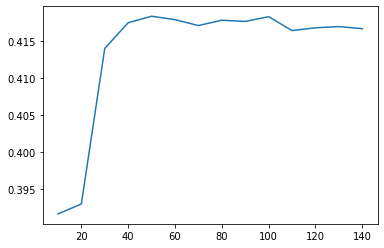

In [ ]:
e=[]
for depth in max_depth:
    forest = RandomForestClassifier(max_depth=depth)
    forest.fit(X_train,y_train)
    yhat=forest.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(max_depth,e)

From the plot above it is safe to assume that the least error is obtained for a max_depth between 10 and 40

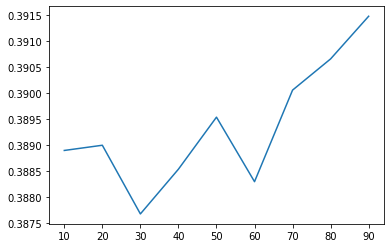

In [ ]:
e=[]
for leaf in min_samples_leaf:
    forest = RandomForestClassifier(min_samples_leaf=leaf)
    forest.fit(X_train,y_train)
    yhat=forest.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(min_samples_leaf,e)

From the plot above it is safe to assume that the least error is obtained for a min_samples between 10 and 30

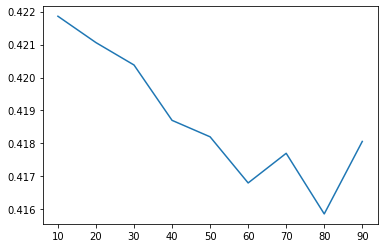

In [ ]:
e=[]
for est in n_estimators:
    forest = RandomForestClassifier(n_estimators=est)
    forest.fit(X_train,y_train)
    yhat=forest.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(n_estimators,e)

From the plot above it is safe to assume that the least error is obtained for a n_estimators between 60 and 80

In [ ]:
# redifining hyperparameters
max_depth = np.arange(10,50,10)
min_samples_leaf=np.arange(10,40,10)
n_estimators = np.array([60,70,80])
param_grid = {'max_depth':max_depth,'min_samples_leaf':min_samples_leaf,'n_estimators':n_estimators}

### Conducting hyper parameter tuning and validation testing with K-Fold method using GridSearchCV

In [ ]:
forest = RandomForestClassifier()
cvf = GridSearchCV(forest,param_grid,return_train_score=True,refit=True,cv=5,scoring = 'roc_auc')

In [ ]:
cvf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([10, 20, 30, 40]),
                         'min_samples_leaf': array([10, 20, 30]),
                         'n_estimators': array([60, 70, 80])},
             return_train_score=True, scoring='roc_auc')

In [ ]:
depth=cvf.best_params_['max_depth']
leaves = cvf.best_params_['min_samples_leaf']
est=cvf.best_params_['n_estimators']

In [ ]:
forest = RandomForestClassifier(max_depth=depth,min_samples_leaf=leaves,n_estimators=est)
forest.fit(X_train,y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=70)

In [ ]:
y_pred=forest.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n',cm)
print('\nClassification report: \n',classification_report(y_test, y_pred))

confusion matrix: 
 [[14019 11087]
 [ 8342 16552]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.63      0.56      0.59     25106
         1.0       0.60      0.66      0.63     24894

    accuracy                           0.61     50000
   macro avg       0.61      0.61      0.61     50000
weighted avg       0.61      0.61      0.61     50000



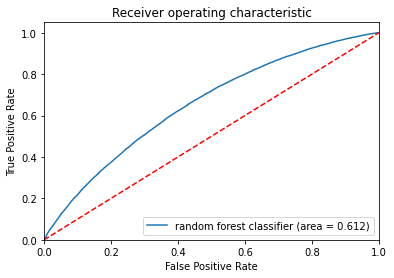

In [ ]:
forest_roc_auc = roc_auc_score(y_test, forest.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='random forest classifier (area = %0.3f)' % forest_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("Test error is " + str(np.mean(y_pred!=y_test)))

Test error is 0.38858


# LightGBM classifier

In [ ]:
import lightgbm as lgb

In [ ]:
# Defining training hyper parameter
fit_params={ 
            'verbose': 100,
            'feature_name': 'auto', # that's actually the default
            'categorical_feature': 'auto' # that's actually the default
           }

Reducing the Hyper parameter search space as performed in Random forest

In [ ]:
num_leaves=np.arange(100,1001,100)
learning_rate=[0.001,0.005,0.01,0.05]

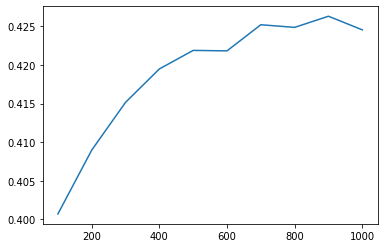

In [ ]:
e=[]
for leaf in num_leaves:
    clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=2000,num_leaves=leaf)   
    clf.fit(X_train,y_train,**fit_params)
    yhat=clf.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(num_leaves,e)

From the plot above it is safe to assume that the least error is obtained for a n_estimators are between 0 and 200

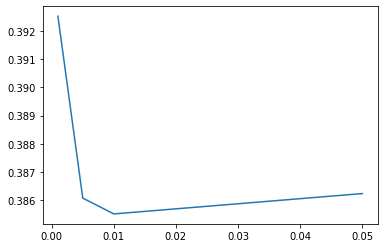

In [ ]:
e=[]
for rate in learning_rate:
    clf = lgb.LGBMClassifier(boosting_type='gbdt',n_estimators=2000,learning_rate=rate)   
    clf.fit(X_train,y_train,**fit_params)
    yhat=clf.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(learning_rate,e)

From the plot above it is safe to assume that the least error is obtained for a n_estimators are between 0.005 and 0.015

In [ ]:
num_leaves=[5,50,100,150,200]
learning_rate=[0.005,0.0075,0.01,0.0125,0.015]
param_grid={'num_leaves':num_leaves,'learning_rate':learning_rate}

In [ ]:
from sklearn.metrics import roc_auc_score
clf = lgb.LGBMClassifier(boosting_type='gbdt', 
                                 n_estimators=2000)
#roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True)
cvf = GridSearchCV(clf,param_grid,return_train_score=True,refit=True,cv=5,scoring = make_scorer(roc_auc_score, greater_is_better=True))

In [ ]:
cvf.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LGBMClassifier(n_estimators=2000),
             param_grid={'learning_rate': [0.005, 0.0075, 0.01, 0.0125, 0.015],
                         'num_leaves': [5, 50, 100, 150, 200]},
             return_train_score=True, scoring=make_scorer(roc_auc_score))

In [ ]:
best_rate=cvf.best_params_['learning_rate']
best_leaf=cvf.best_params_['num_leaves']

In [ ]:
clf = lgb.LGBMClassifier(boosting_type='gbdt', learning_rate=best_rate,num_leaves=best_leaf,
                                 n_estimators=2000)
clf.fit(X_train,y_train,**fit_params)

LGBMClassifier(learning_rate=0.0075, n_estimators=2000, num_leaves=50)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n',cm)
print('\nClassification report: \n',classification_report(y_test, y_pred))

confusion matrix: 
 [[13928 11178]
 [ 8092 16802]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.63      0.55      0.59     25106
         1.0       0.60      0.67      0.64     24894

    accuracy                           0.61     50000
   macro avg       0.62      0.61      0.61     50000
weighted avg       0.62      0.61      0.61     50000



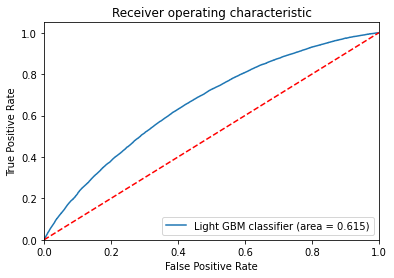

In [ ]:
clf_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='Light GBM classifier (area = %0.3f)' % clf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print("Test error is " + str(np.mean(y_pred!=y_test)))

Test error is 0.3854


# XGBoost classifier

In [10]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

In [11]:
# define hyperparameters
min_child_weight=np.arange(1,11,1)
max_depth=np.arange(1,11,1)
gamma=np.arange(0,6,0.5)
subsample=np.arange(0,1,0.2)
colsample_bytree=np.arange(0,1.2,0.2)
reg_alpha=[0.01,0.05 ,0.1, 0.15,0.2,0.25,0.3,0.35,0.4]
learning_rate=[0.01,0.05,0.1,0.15,0.2,0.25,0.3]

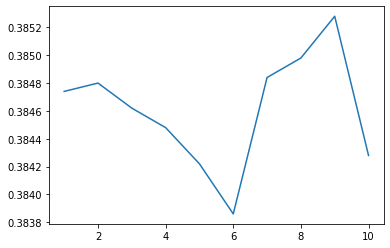

In [ ]:
e=[]
for child_weight in min_child_weight:
    xgb = XGBClassifier(min_child_weight=child_weight,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(min_child_weight,e)

From the plot above it is safe to assume that the least error is obtained for min_child_weight between 4 and 8

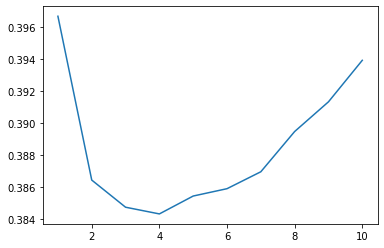

In [ ]:
e=[]
for depth in max_depth:
    xgb = XGBClassifier(max_depth=depth,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(max_depth,e)

From the plot above it is safe to assume that the least error is obtained for max_depth in between 3 and 5

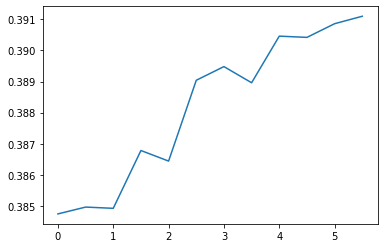

In [ ]:
e=[]
for g in gamma:
    xgb = XGBClassifier(gamma=g,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(gamma,e)

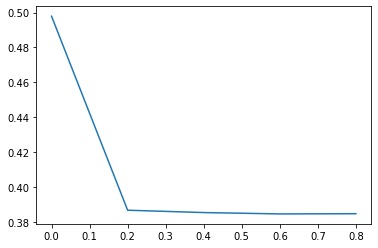

In [ ]:
e=[]
for ss in subsample:
    xgb = XGBClassifier(subsample=ss,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(subsample,e)

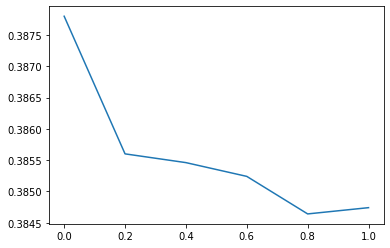

In [ ]:
e=[]
for col in colsample_bytree:
    xgb = XGBClassifier(colsample_bytree=col,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(colsample_bytree,e)

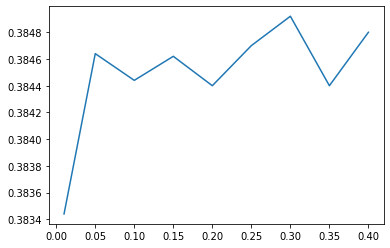

In [ ]:
e=[]
for alpha in reg_alpha:
    xgb = XGBClassifier(reg_alpha=alpha,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(reg_alpha,e)

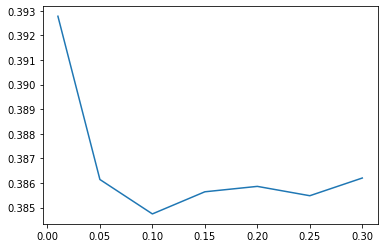

In [ ]:
e=[]
for rate in learning_rate:
    xgb = XGBClassifier(learning_rate=rate,n_estimators=1000,objective= 'binary:logistic')
    xgb.fit(X_train,y_train)
    yhat=xgb.predict(X_test)
    e.append(np.mean(yhat!=y_test))
plt.plot(learning_rate,e)

In [12]:
# redefine hyperparameters
from sklearn.model_selection import RandomizedSearchCV
min_child_weight=[5,6,7]
max_depth=[3, 4, 5]
gamma=[0.1,0.5, 1]
subsample=[0.6, 0.8, 1.0]
colsample_bytree=[0.6, 0.8, 1.0]
reg_alpha=[0.01,0.02,0.03]
learning_rate=[0.05,0.10,0.15]
param_grid={'min_child_weight':min_child_weight,
            'max_depth':max_depth,
            'gamma':gamma,
            'subsample':subsample,
            'colsample_bytree':colsample_bytree,
            'reg_alpha':reg_alpha,
            'learning_rate':learning_rate
            }


In [13]:
xgb=XGBClassifier(n_estimators=1000,objective='binary:logistic')
xgb_cv = RandomizedSearchCV(xgb,param_grid,return_train_score=True,refit=True,cv=5,scoring = make_scorer(roc_auc_score, greater_is_better=True))

In [14]:
xgb_cv.fit(X_train,y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=1000,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, s...
                                        'learning_rate': [0.01, 0.05, 0.1, 0.15,
                                                          0.2, 0.25, 0.3],
                     

In [15]:
best_min_child_weight=xgb_cv.best_params_['min_child_weight']
best_max_depth=xgb_cv.best_params_['max_depth']
best_gamma=xgb_cv.best_params_['gamma']
best_subsample=xgb_cv.best_params_['subsample']
best_colsample_bytree=xgb_cv.best_params_['colsample_bytree']
best_reg_alpha=xgb_cv.best_params_['reg_alpha']
best_learning_rate=xgb_cv.best_params_['learning_rate']

In [16]:
xgb_cv.best_params_

{'colsample_bytree': 0.4,
 'gamma': 4.0,
 'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 10,
 'reg_alpha': 0.4,
 'subsample': 0.2}

In [17]:
xgb=XGBClassifier(n_estimators=1000,
                  objective='binary:logistic',
                  min_child_weight=best_min_child_weight,
                  max_depth=best_max_depth,
                  gamma=best_gamma,
                  subsample=best_subsample,
                  colsample_bytree=best_colsample_bytree,
                  reg_alpha=best_reg_alpha,
                  learning_rate=best_learning_rate)
xgb.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=4.0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=10, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.2, verbosity=1)

In [20]:
y_pred=xgb.predict(X_test)

In [21]:
cm = confusion_matrix(y_test, y_pred)
print('confusion matrix: \n',cm)
print('\nClassification report: \n',classification_report(y_test, y_pred))

confusion matrix: 
 [[13892 11214]
 [ 7871 17023]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.64      0.55      0.59     25106
         1.0       0.60      0.68      0.64     24894

    accuracy                           0.62     50000
   macro avg       0.62      0.62      0.62     50000
weighted avg       0.62      0.62      0.62     50000



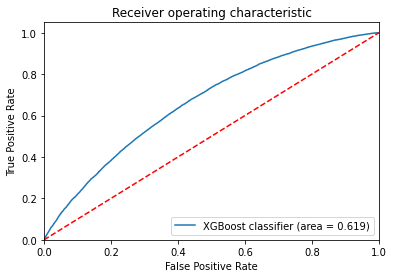

In [22]:
xgb_roc_auc = roc_auc_score(y_test, xgb.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, xgb.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr, tpr, label='XGBoost classifier (area = %0.3f)' % xgb_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [23]:
print("Test error is " + str(np.mean(y_pred!=y_test)))

Test error is 0.3817


# Results

In [24]:
columns=['Classifier','Test Error(%)','AUC Score']
results = pd.DataFrame(columns=columns)
results['Classifier'] = np.array(['Random Forest','LGB classifier','XGBoost Classifier'])
results['Test Error(%)'] = np.array([38.85,38.54,38.17])
results['AUC Score'] = np.array([0.612,0.615,0.619])
results

,Classifier,Test Error(%),AUC Score
0,Random Forest,38.85,0.612
1,LGB classifier,38.54,0.615
2,XGBoost Classifier,38.17,0.619


# Explaining the Model

## variable importance plot

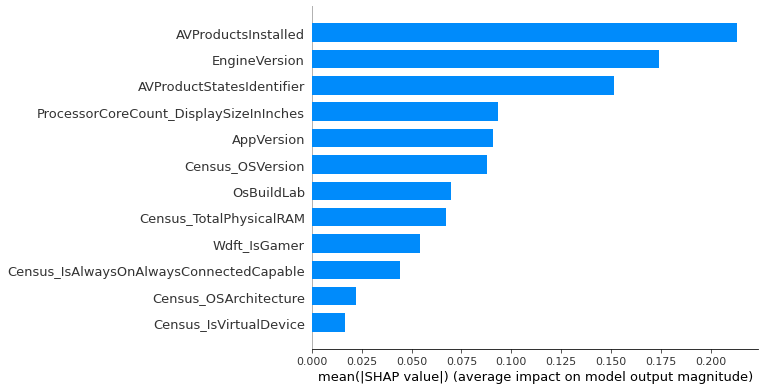

In [27]:

import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

top three varibles the model is depedent mostly are AVProductsInstalled, EngineVersion, AVProductStatesIdentifier

### positive or negative impact of variable on the model

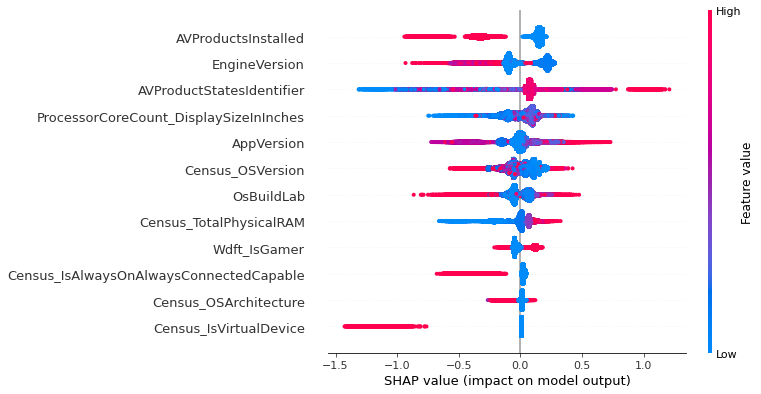

In [30]:
import matplotlib.pyplot as plt
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

- AVProductsInstalled is negatively corelated with target
- EngineVersion is negatively corelated with target
- AVProductStatesIdentifier is positively corelated with the target